In [1]:
#import packages
import tmdbsimple as tmdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import requests
import configparser
import pickle
import string
import nltk
from copy import deepcopy
import random 


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import PorterStemmer

#modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve

#pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer, Imputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve


import time
import collections
from PIL import Image
import sys

from datetime import datetime, timedelta, date

In [2]:
users = pd.read_csv('takehome_users.csv',  encoding='cp1252')
activity = pd.read_csv('takehome_user_engagement.csv')

In [3]:
users.shape

(12000, 10)

In [4]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [7]:
users.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

In [8]:
activity = activity.set_index(pd.DatetimeIndex(activity['time_stamp']))
activity.head()

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1


In [9]:
#get users who were active at least 3 times in a week
grouped = activity.groupby('user_id')['visited'].resample('1W').sum()
grouped = grouped.to_frame().reset_index()
active_users = list(grouped.loc[grouped['visited'] >= 3, 'user_id'].unique())

In [10]:
#create indicator in users dataframe to indicate active users
users['active'] = users.object_id.apply(lambda x: 1 if x in active_users else 0)

In [11]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


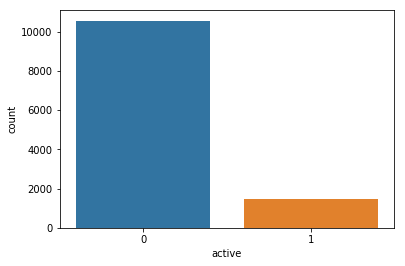

In [12]:
sns.countplot(x = 'active', data = users)

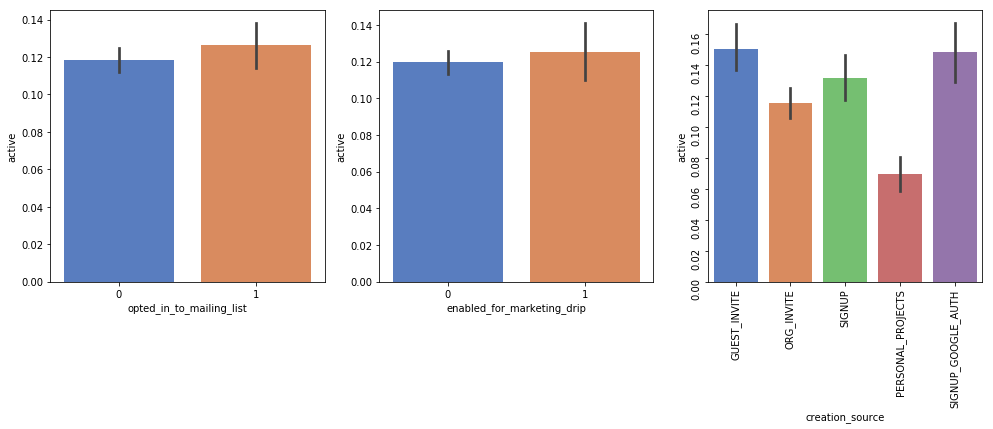

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3,figsize=(16.7, 5))

sns.catplot(ax = ax1, x="opted_in_to_mailing_list", y="active", data = users, 
                   height=6, kind="bar", palette="muted")
sns.catplot(ax = ax2, x="enabled_for_marketing_drip", y="active", data = users, 
                   height=6, kind="bar", palette="muted")
sns.catplot(ax = ax3, x="creation_source", y="active", data = users, 
                   height=6, kind="bar", palette="muted")

ax3.tick_params(labelrotation=90)

plt.close(2)
plt.close(3)
plt.close(4)

In [14]:
#one hot encode creation source
creation_groups = pd.get_dummies(users['creation_source'], prefix='source', drop_first= True)
users = pd.concat([users, creation_groups], axis =1)

#one hot encode org id
org_groups = pd.get_dummies(users['org_id'], prefix='org', drop_first= True)
users = pd.concat([users, org_groups], axis =1)

In [23]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,org_407,org_408,org_409,org_410,org_411,org_412,org_413,org_414,org_415,org_416
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,...,0,0,0,0,0,0,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,...,0,0,0,0,0,0,0,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,...,0,0,0,0,0,0,0,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,...,0,0,0,0,0,0,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
#Helper Functions

#Construct Pipeline
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select columns from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class ArrayTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to select columns from the data frame to change to array
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X[self.key])



def make_pipline(cat_cols):
    oth_cols = Pipeline([
                ('others', ArrayTransformer(cat_cols))
                ])
    pipeline = Pipeline([
            ('others', oth_cols),
            ('clf', SGDClassifier(loss = 'log', 
                                 penalty = 'elasticnet', 
                                 max_iter = 120, 
                                 class_weight = 'balanced'
                                 ))
           ])
    return pipeline


def grid_search_train(X_train, y_train, pipeline, param_grid, metric):
    cv_grid = GridSearchCV(pipeline, param_grid = param_grid, scoring = metric, cv = 10, verbose = 1)
    model = cv_grid.fit(X_train, y_train)
    
    print('Parameters:', model.best_params_)
    print('Best %s Score:' %metric, model.best_score_)
    
    return model

# Compute ROC curve and ROC area
def roc_stats(X_test, y_test, model):
    
    #generate data
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    y_predict = model.predict(X_test)
    
    accuracy = accuracy_score(y_test,y_predict)
    recall = recall_score(y_test,y_predict)
    precision = precision_score(y_test,y_predict)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    #print stats
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_predict))
    print('Accuracy: %.3f%%' % (accuracy*100))
    print('Recall: %.3f%%' % (recall*100))
    print('Precision: %.3f%%' % (precision*100))
    
#Get feature importances by getting accuracy per each feature
def get_coeff(model, cols):
    coefficients = model.best_estimator_.named_steps['clf'].coef_
    coefficients = np.squeeze(coefficients)
    coefficients = pd.DataFrame(
        {'features': cols,
         'coefficients': coefficients
        })
    
    coefficients.set_index('features', inplace = True)
    coefficients['abs'] = abs(coefficients['coefficients'])
    coefficients.sort_values(by= ['abs'], ascending = False, inplace = True)
    
    return coefficients


In [29]:
#specify columns
drop_cols = ['object_id',
             'creation_time', 
             'name', 
             'email', 
             'creation_source',
             'last_session_creation_time',
             'org_id',
             'invited_by_user_id',
             'active']


X_train, X_test, y_train, y_test = (train_test_split(users.drop(columns = drop_cols), 
                                                     users['active'],
                                                     test_size = 0.30, 
                                                     random_state = 412))

cols = list(X_train.columns.values)

#categorical columns
cat_cols = cols


In [30]:
pipeline = make_pipline(cat_cols)

#Create a list of classifiers to test#Create  
clfs = []
clfs.append(SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120, class_weight = 'balanced'))
clfs.append(KNeighborsClassifier())
clfs.append(RandomForestClassifier( class_weight = 'balanced'))
clfs.append(SVC())
clfs.append(AdaBoostClassifier())
clfs.append(GradientBoostingClassifier())

#Run through the pipeline for each classifier in the list
#Can take awhile to run
for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train, scoring = 'recall', return_train_score = False, cv = 5)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())

---------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=120, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
-----------------------------------
fit_time  mean  2.3251765727996827
fit_time  std  0.016405228614318125
score_time  mean  0.007278060913085938
score_time  std  0.001747506664340652
test_score  mean  0.44168656716417914
test_score  std  0.10012994008221912
---------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
-----------------------------------
fit_time  mean  0.23586454391479492
fit_time  std  0.008254925745974305
score_time  mean  2.2417235374450684
score_time  std  0.1041643095

In [33]:
graboost = GradientBoostingClassifier(max_features='sqrt')
parametergra = {'n_estimators':[40,45,50,55,60],'learning_rate':[.01,0.02,0.03,0.04,0.05],
              'max_depth':[1,2,3,4,5]}
grid1 = GridSearchCV(estimator=graboost,param_grid=parametergra,
                     scoring='accuracy',cv=5)
grid1.fit(X_train,y_train)
best_para_gra = grid1.best_params_
best_acc_gra = grid1.best_score_


In [34]:
print('The Tuned Paratmers :\n',best_para_gra,'\nAchieved %s Percent Accuracy' %(best_acc_gra*100))

The Tuned Paratmers :
 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 40} 
Achieved 88.08333333333334 Percent Accuracy


In [36]:
gbm = GradientBoostingClassifier(max_features='sqrt',
                                 n_estimators=40,learning_rate=.01,max_depth= 1)
gbm.fit(X_train,y_train)
feature_coef = pd.DataFrame(gbm.feature_importances_).transpose()
feature_coef.columns = list(X_train.columns)
feature_coef.index = ['GBM'] 
feature_coef.transpose().sort_values(by='GBM',ascending=False)

,GBM
source_PERSONAL_PROJECTS,0.125
org_345,0.075
org_400,0.050
org_86,0.050
org_270,0.050
org_235,0.050
org_62,0.050
org_177,0.050
org_306,0.050
org_388,0.025


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 10.1min finished


Parameters: {'clf__l1_ratio': 0.3333333333333333}
Best accuracy Score: 0.6123809523809524


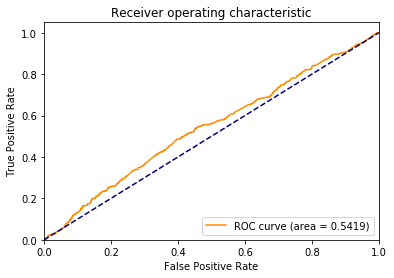

Confusion Matrix: 
 [[2014 1142]
 [ 252  192]]
Accuracy: 61.278%
Recall: 43.243%
Precision: 14.393%


In [37]:
param_grid = {
    'clf__l1_ratio' :  np.linspace(0,1,25),
    }

metric = 'accuracy'

pipeline = make_pipline(cat_cols)
model = grid_search_train(X_train, y_train, pipeline, param_grid, metric = metric)
roc_stats(X_test, y_test, model)